# Text Mining met Python - OVV Rapporten

|   |   |
|------|------|
|__Auteur__ | Marlon van den Hoek  |
| __E-mail__  | <m.vandenhoek@onderzoeksraad.nl>  |
| __Onderwerpen__ | text mining, cleansing, tokenizing, stemming, stopwords, TF-IDF, Jaccard similarity, KMeans, hierarchical document clustering, LDA, sentiment analysis |
| __Afhankelijkheden__ | `nltk`, `textmining`, `pdfminer`, `re`, `multiprocessing`, `sklearn`, `pandas`, `gensim`, `mpld3` (alleen voor plotting) |
|__Datum__ | 14-02-2018 |
| __Versie__ | `0.6` |

_Opmerking 1_: Om dit Jupyter Notebook correct te kunnen runnen moeten eerst de juiste pakketten (zie afhankelijkheden) geinstalleerd worden. Dit kan bijvoorbeeld met `pip`. Zie hiervoor de eerste cell hier onder.

_Opmerking 2_: Dit notebook is standaard beperkt tot 30 documenten. Om alle documenten te analyseren, verwijder de limiet van 30 bij het laden: verander `arange` bij de for loop, `job` bij de multicore loop.

In [ ]:
# To install the dependencies, run the following code -- run only once!!
! pip install nltk
! pip install textmining
! pip install pdfminer
! pip install multiprocessing
! pip install sklearn
! pip install gensim
! pip install mpld3 # for d3.js plotting

## Introductie

In dit Jupyter notebook gaan we aan de slag met text mining op de (openbare) rapporten van de Onderzoeksraad. Met een ander script (scraper) zijn meer dan 600 rapporten van de OVV website gedownload. Daarin is rekening gehouden met andere documenten zoals errata, bijlagen, aanbevelingen; deze documenten zijn voor het grootste gedeelte uit de collectie gefilterd. Deze documenten zijn opgeslagen in `./Rapporten/`.

Omdat de meeste rapporten van de OVV zijn voorzien van een beveiliging tegen het kopieren van tekst, zijn alle rapporten eerst gedecrypt met een extern programma. De gedecrypte bestanden zijn te vinden in de map `./Rapporten decrypted/`. De onderliggende submappen geven de taal van het document aan: Nederlands `nl` of Engels `en`.

Er is een handmatige selectie van rapporten gemaakt en geplaatst in `./Rapporten selectie/nl` met een validatie set in `./Rapporten selectie/validatie`.

Voor het minen maken we gebruik van de natural language toolkit ([NLTK](http://www.nltk.org/)), het textmining pakket ([textmining1.0](https://pypi.python.org/pypi/textmining/1.0)) en het boek _Natural Language Processing with Python_<sup id="a1">[1](#f1)</sup>. Daarnaast maken we ook gebruik van pakketten voor lineaire algebra en matrix operaties, e.a. Deze pakketten importeren we eerst.

<b id="f1">1</b> Bird, S., Klein, E., & Loper, E. (2009). Natural language processing with Python: analyzing text with the natural language toolkit. "O'Reilly Media, Inc.". [↩](#a1)

In [2]:
# import dependencies
import numpy as np
import nltk, textmining

## Text laden

Als we gebruik willen maken van onze eigen corpus, database met text, dan moeten we de rapporten die gedownload zijn in pdf eerst converteren naar plain text (txt). Hiervoor gebruiken we `pdfminer`. Metadata halen we uit de pdf bestanden met het pakket `pyPdf` omdat deze sneller is.

In de volgende code importeren we eerst alle pakketten die nodig zijn, daarna definieren we de bestandlocatie en creeeren we een functie om een bestand te kunnen lezen. In deze functie wordt elke pagina van het desbetreffende bestand geparsed en bij elkaar gevoegd.

In [5]:
# import packages
import sys
import os
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, HTMLConverter, TextConverter
from pdfminer.layout import LAParams
from cStringIO import StringIO
from pyPdf import PdfFileReader # extract pdf metadata

# Define language
lang = 'nl'

# Define location of reports
#FilePath = './Rapporten decrypted/' + lang + '/'
FilePath = './Rapporten selectie/' + lang + '/'

# Get files in folder
FileNames = os.listdir(FilePath)

# Make function to convert pdf to text
def pdfparser(FilePath,FileName): 
    fp = file(FilePath+FileName, 'rb')
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    
    # Process each page contained in the document.
    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        data =  retstr.getvalue()
    
    # return text
    return data


Nu de functie om een bestand te lezen gedefineerd is kunnen we deze functie toe gaan passen op alle bestanden. We doen dit door over de bestanden heen te loopen.

In de loop gebeurt het volgende: 
1. het bestand wordt gelezen
2. de metadata wordt gelezen en opgeslagen in de dict `metadict`
3. met het Regexp `re` pakket splitten we de tekst
4. converteren de tekst naar lower case
5. uitfilteren van lege indices
6. uitfilteren van numerieke waarden
7. als de overgebleven body niet `None` is dan voegen we de tokens toe aan dict `textdict`

_**Let op**_ om geparallelliseerd bestanden te lezen en converteren, sla de volgende stappen over en ga naar [hier](#parallel). Als je systeem voorzien is van meerdere cores kan dit significant sneller zijn!

In [ ]:
# use regexp package to split
import re

#textbody = np.array([])
#fulltextmat = []   # update: niet meer nodig! laten staan ivm fallback
textdict = {}
metadict = {}
#textmat = []
#for i in np.arange(np.shape(FileName)[0]): # use this line for all files
for i in np.arange(0,30): # temp only take first 30 files
    print "Processing ",i+1,'/',np.shape(FileNames)[0],': ', FileNames[i],'\n'
    
    try:
        data = pdfparser(FilePath,FileNames[i])
        
        # add to fulltextmat
        #fulltextmat.append(data)
        
        # get PDF metadata
        pdfi = PdfFileReader(open("".join([FilePath,FileNames[i]]), "rb"))
        pdfi = pdfi.getDocumentInfo()
        metadict[FileNames[i]] = pdfi

        # split text
        data = np.array(re.split('\W+',data),dtype=str) # tokenize text
        
        # convert all data to lower case
        data = np.array([w.lower() for w in data])

        # filter out empty cells
        ind = data != ''
        data = data[ind]

        # filter out non-alpha strings
        ind = np.char.isalpha(data)
        data = data[ind]

        if data.size is not 0:
            # filter out strings with length = 1
            strlen = np.vectorize(len)
            ind = strlen(data) != 1
            data = data[ind]

            # add to textbody array
            #textbody = np.append(textbody,data)
        
            # also add data to dict and matrix for later use
            textdict[FileNames[i]] = list(data)
            #textmat.append(list(data))

    except ValueError:
        print "Skipping ", FileNames[i]

### Geparallelliseerd bestanden lezen en converteren
 <a name="parallel"></a>
 
Om een groot gedeelte van de `for` loops sneller te maken, kunnen we de processen parallelliseren met `multiprocessing`. Dit pakket moeten we eerst importeren en dan definieren wat we ermee willen doen.

Om het uitlezen van bestanden te kunnen faciliteren moeten we ook eerst een functie definieren om een bestand te lezen en cleanen, deze functie noemen we _processandtokenize_. Deze functie wordt parallel uitgevoerd en de output is een dict met daarin al onze bestandnamen en bijbehorende tokens.

_Let op_: het runnen van onderstaande code is erg CPU intensief en kan ervoor zorgen dat je systeem langzaam wordt gedurende het processen van de data.

In [6]:
import multiprocessing
import re

def processandtokenize(FileName, dictname, metadict): 
    
    # print progress, var FileNames is taken from shared memory, not required as function input
    print "Processing: ",int(np.arange(0,len(FileNames))[np.array(FileNames) == FileName])+1,'/',len(FileNames), FileName
    
    try:
        data = pdfparser(FilePath,FileName)
        
        # get PDF metadata
        pdfi = PdfFileReader(open("".join([FilePath,FileName]), "rb"))
        pdfi = pdfi.getDocumentInfo()
        metadict[FileName] = pdfi

        # split text
        data = np.array(re.split('\W+',data),dtype=str) # tokenize text
        
        # convert all data to lower case
        data = np.array([w.lower() for w in data])

        ## filter out empty cells
        ind = data != ''
        data = data[ind]

        ## filter out non-alpha strings
        ind = np.char.isalpha(data)
        data = data[ind]

        if data.size is not 0:
            # filter out strings with length = 1
            strlen = np.vectorize(len)
            ind = strlen(data) != 1
            data = data[ind]
        
        # add data to dict
        dictname[FileName] = list(data)

    except ValueError:
        print "Skipping ", FileName
        

# initialize multi-core process
manager = multiprocessing.Manager()
textdict = manager.dict()
metadict = manager.dict()

# define job
#job = [multiprocessing.Process(target=processandtokenize, args=(i, textdict, metadict)) for i in FileNames[0:30]] # first 30 files
job = [multiprocessing.Process(target=processandtokenize, args=(i, textdict, metadict)) for i in FileNames] # for all files


# start all jobs in the job list
_ = [p.start() for p in job]
_ = [p.join() for p in job]

# convert the multiprocess textdict opject to normal dict
textdict = dict(textdict)
metadict = dict(metadict)

Processing:  1 / 72 2b77c6223671b-rapport-vliegtuig-verongelukt-in-de-noordzee-nl.pdf
Processing:  2 / 72 1ea928de52842012037-rapport-overig-verkeer-in-nabijheid-nl-def.pdf
Processing:  3 / 72 3bbcbbb715a5b-rapport-negen-starts-van-een-niet-beschikbaar-gestelde-baan.pdf
Processing:  4 / 72 4dfc09f32e65rapport-den-uylbrug-nl-interactief.pdf
Processing:  5 / 72 4e4564b46952rapport-salmonella-nl-web.pdf
Processing:  7 / 72 7ccfd26136c6b-rapport-victoriaborg-nl.pdf
Processing:  6 / 72 5a9ac843cf54b-rapport-marietje-andrea-nl-interactief.pdf
Processing:  8 / 72 8c6a4a5cf9cdrapport-uitgeest-nl-web.pdf
Processing:  9 / 72 8cbb534baa5erapport-neergestort-in-circuit-web.pdf
Processing:  10 / 72 9c15f17d86dfb-rapport-koolmonoxide-in-boegschroefruimte-nl.pdf
Processing:  11 / 72 21e514bcde47odfjell2-rapport-nl-interactief2.pdf
Processing:  12 / 72 33ef77ab629erapport-gaswinning-groningen-nl-interactief.pdf
Processing:  13 / 72 35f9d09a0e79rapport-vreemdelingen-interactief.pdf
Processing:  15 / 72

In [7]:
print 'Total number of tokens: ',np.shape(sum(list(textdict.values()),[]))[0]


Total number of tokens:  1622188


## Text stemming

Nu alle woorden uit de text gehaald zijn en in een `numpy` array staan kunnen we de woorden gaan _stemmen_. We gebruiken hiervoor de Porter stemmer voor het Engels en de Snowball stemmer in de NLTK toolkit voor het Nederlands.

Let op: de huidige implementatie van de Snowball stemmer is verre van perfect voor de Nederlandse taal. Deze stap kan ook overgeslagen worden.

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

print "Supported Languages Snowball: \n"
print(" ".join(SnowballStemmer.languages))
print "\n"

print "Supported Languages Porter: \n"
print "english\n"

print "Processing ", lang, "stopwords\n"

# create a new instance
if lang == 'nl':
    stemmer = SnowballStemmer("dutch")
elif lang == 'en':
    stemmer = PorterStemmer()

for i in np.arange(0,np.shape(textdict.keys())[0]):
    text_stemmed = []
    print i+1,'/',np.shape(textdict.keys())[0]
    for j in np.arange(0,np.shape(textdict.values()[i])[0]):
        text_stemmed.append(stemmer.stem(textdict.values()[i][j]))
    textdict[textdict.keys()[i]] = text_stemmed


## Stopwords verwijderen

Om onze teksten te processen moeten we nog een cleansing stap uitvoeren: het verwijderen van de stopwords. Hiervoor gebruiken we de standaard NL/EN library in de NLTK toolkit. Om een overzicht te krijgen van de stopwords in het NLTK pakket, gebruik het commando in de tweede cell. Het is mogelijk om hier meer woorden aan toe te voegen.

In [10]:
# Import required packages
from nltk.corpus import stopwords
from collections import Counter

In [11]:
# Print the stopwords
print stopwords.words('dutch')

[u'de', u'en', u'van', u'ik', u'te', u'dat', u'die', u'in', u'een', u'hij', u'het', u'niet', u'zijn', u'is', u'was', u'op', u'aan', u'met', u'als', u'voor', u'had', u'er', u'maar', u'om', u'hem', u'dan', u'zou', u'of', u'wat', u'mijn', u'men', u'dit', u'zo', u'door', u'over', u'ze', u'zich', u'bij', u'ook', u'tot', u'je', u'mij', u'uit', u'der', u'daar', u'haar', u'naar', u'heb', u'hoe', u'heeft', u'hebben', u'deze', u'u', u'want', u'nog', u'zal', u'me', u'zij', u'nu', u'ge', u'geen', u'omdat', u'iets', u'worden', u'toch', u'al', u'waren', u'veel', u'meer', u'doen', u'toen', u'moet', u'ben', u'zonder', u'kan', u'hun', u'dus', u'alles', u'onder', u'ja', u'eens', u'hier', u'wie', u'werd', u'altijd', u'doch', u'wordt', u'wezen', u'kunnen', u'ons', u'zelf', u'tegen', u'na', u'reeds', u'wil', u'kon', u'niets', u'uw', u'iemand', u'geweest', u'andere']


In [12]:
# Loop over files and remove stopwords
for i in np.arange(0,np.shape(textdict.keys())[0]):
    print i+1,'/',np.shape(textdict.keys())[0]
    if lang == 'nl':
        text_nostopw = [w for w in textdict.values()[i] if not w in stopwords.words('dutch')]
    elif lang == 'en':
        text_nostopw = [w for w in textdict.values()[i] if not w in stopwords.words('english')]
    textdict[textdict.keys()[i]] = text_nostopw

# trick to flatten matrix: sum(list(textdict.values()),[])
count = Counter(sum(list(textdict.values()),[]))

# print de meest voorkomende woorden na het verwijderen van de stopwords
print count.most_common(100)

1 / 72
2 / 72
3 / 72
4 / 72
5 / 72
6 / 72
7 / 72
8 / 72
9 / 72
10 / 72
11 / 72
12 / 72
13 / 72
14 / 72
15 / 72
16 / 72
17 / 72
18 / 72
19 / 72
20 / 72
21 / 72
22 / 72
23 / 72
24 / 72
25 / 72
26 / 72
27 / 72
28 / 72
29 / 72
30 / 72
31 / 72
32 / 72
33 / 72
34 / 72
35 / 72
36 / 72
37 / 72
38 / 72
39 / 72
40 / 72
41 / 72
42 / 72
43 / 72
44 / 72
45 / 72
46 / 72
47 / 72
48 / 72
49 / 72
50 / 72
51 / 72
52 / 72
53 / 72
54 / 72
55 / 72
56 / 72
57 / 72
58 / 72
59 / 72
60 / 72
61 / 72
62 / 72
63 / 72
64 / 72
65 / 72
66 / 72
67 / 72
68 / 72
69 / 72
70 / 72
71 / 72
72 / 72
[('veiligheid', 3848), ('onderzoeksraad', 3353), ('veilig', 3204), ('risico', 2755), ('lucht', 2673), ('informatie', 2382), ('the', 2294), ('tussen', 2272), ('toezicht', 2147), ('partijen', 2020), ('heid', 2009), ('bedrijven', 1968), ('tijdens', 1922), ('zoals', 1897), ('onderzoek', 1892), ('ten', 1860), ('zoek', 1826), ('raad', 1825), ('alle', 1796), ('betrokken', 1713), ('twee', 1707), ('aantal', 1694), ('mogelijk', 1683), ('be


## Jaccard Similarity

Om verschillende documenten met elkaar te vergelijken maken we gebruik van de _Jaccard Similarity_: $J\left(A,B\right) = \frac{|A\bigcap B|}{|A\bigcup B|}$. Dit is de lengte van de intersectie (overeenkomst) van de set tokens van tekst $A$ en tekst $B$ gedeeld door de union (hele collectie) van beide sets. Deze measure geeft de numerieke overeenkomst, op een schaal van 0-1, tussen twee documenten. Met andere woorden: de Jaccard Similarity is een fractie die aangeeft hoeveel van tekst $A$ en $B$ overeenkomen. Set $A$ en set $B$ hoeven niet per definitie de zelfde grootte of lengte te hebben.

![Image of Yaktocat](http://4.bp.blogspot.com/-x1n8llkCjuc/UAyeWdyc3EI/AAAAAAAAAU8/ron4CjbDVDM/s1600/DATA+SETS.png)

In [21]:
# define Jaccard similarity
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/len(union)

# calculate the Jaccard similarity of text 1 and text 2
A = textdict.values()[0]
B = textdict.values()[1]
print jaccard_similarity(A,B)


0.136094674556


De Jaccard Similarity kan op veel verschillende manieren worden berekend. We kunnen de measure berekenen voor:
1. de bag of words zonder rekening te houden met woordfrequentie, we gebruiken dan alleen de set met unieke woorden voor beide teksten
2. eerst de stopwords verwijderen en dan de bag of words gebruiken zonder frequentie
3. rekening houden met de woordfrequentie
4. meer geavanceerde methodes zoals k-shingles of n-grams

In deze implementatie is ervoor gekozen om 2. te gebruiken (afhankelijk van de eerder uitgevoerde stappen kan ook 1. gebruikt worden).

Om de intersectie van beide teksten te bekijken, gebruik het volgende commando:

In [26]:
# to check the intersection of both texts:
set(A).intersection(set(B))

{'aantal',
 'achterste',
 'af',
 'afhankelijk',
 'algemene',
 'alle',
 'alleen',
 'analyse',
 'basis',
 'bedoeld',
 'bedrijven',
 'bedroeg',
 'begin',
 'behulp',
 'bemanningsleden',
 'beschikbaar',
 'besluit',
 'betrokken',
 'bezoekadres',
 'bijlage',
 'binnen',
 'boord',
 'boven',
 'bracht',
 'bron',
 'buiten',
 'buurt',
 'circuit',
 'ck',
 'conclusies',
 'constateerde',
 'contact',
 'controleren',
 'daarbij',
 'daarna',
 'daarnaast',
 'daarom',
 'data',
 'deel',
 'den',
 'derde',
 'dient',
 'direct',
 'diverse',
 'doordat',
 'dr',
 'drie',
 'echter',
 'eerst',
 'eerste',
 'eigendom',
 'enige',
 'enkele',
 'ervaring',
 'extra',
 'fase',
 'figuur',
 'gaan',
 'gaf',
 'gebruik',
 'gebruikt',
 'gedaan',
 'geldig',
 'gemaakt',
 'gevaar',
 'gevallen',
 'gevolg',
 'gevolgd',
 'gezien',
 'ging',
 'goed',
 'google',
 'grote',
 'haag',
 'heavy',
 'hierbij',
 'hierdoor',
 'hoogte',
 'ingezet',
 'inhoud',
 'internet',
 'jaar',
 'joustra',
 'keek',
 'keer',
 'knopen',
 'kreeg',
 'kwam',
 'laatste'

## TF-IDF - _term frequency-inverse document frequency_

Om het belang van verschillende woorden in een corpus numeriek uit te drukken berekenen we de TF-IDF. Dit doen we door gebruik te maken van de functie `feature_extraction` in de `sklearn` toolbox (onderdeel van `scikit`). 

De TF-IDF measure reflecteert hoe belangrijk een woord voor een document is door in eerste instantie te kijken hoe vaak een woord voor komt in een tekst. In het meest simpele geval gebruiken we hiervoor de woordfrequentie $f_{t,d}$. Ons algorimte maakt gebruik van de geaugmenteerde woordfrequentie $tf$:

$\text{tf}(t,d) = 0.5 + \frac{0.5 ~\times ~f(t,d)}{\text{max}\left\{ f(w,d):~w~\in ~d\right\}}$

waarin de noemer de maximale woordfrequentie aangeeft.

Omdat sommige woorden vaak in tekst aanwezig zijn maar eigenlijk weinig betekenis hebben maken we gebruik van de inverse document frequentie om de uitkomst van de woord frequentie te reguleren. De IDF is gedefinieerd als:

$ \text{idf}(t) = \log \frac{n_d}{df\left( d,t \right)} + 1$

hierin is $n_d$ het totaal aantal documenten en $df\left(t,d\right)$ het aantal documenten dat term $t$ bevat.

De TF-IDF krijgen we dan door:

$ \text{tf-idf}(t,d) = \text{tf}(t,d) \times \text{idf}(t)$

De TF-IDF wordt berekend voor alle unieke termen $t$ in alle unieke documenten $d$. De resulterende matrix heeft dus de dimensie $\left( t,d \right)^{\intercal}$ waarin element ($t_i,d_j)^{\intercal}$ de numerieke relevantie geeft van term $i$ in document $j$.

![Image of Yaktocat](http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402)

#### Limitatie bag of words
Omdat een simpel bag of words model geen rekening houdt met verkeerd gespelde woorden/typo's kunnen deze woorden als verschillend worden gezien door het algoritme. Om dit te voorkomen kunnen we gebruik maken van een collectie bigrams (n=2) of ngrams (n>2). Met een analyzer (in dit geval `char_wb`) en een gedefinieerde `ngram_range` kunnen we woorden dan herkennen aan $n$ features. Zo kunnen we voorkomen dat simpele fouten invloed hebben op het model.

**Let op**: hoe meer ngrams features, hoe meer geheugen nodig is!

#### Tokenizer definitie<a name="limitatie"></a>
Omdat `Tfidfvectorizer` alleen de volledige tekst als string accepteert moeten we eerst de tokens in `textdict` manipuleren -> we voegen de tokens samen tot een string en splitten die dan weer op de spatie tussen woorden. Dit is een workaround en genereert een kleine overhead.

#### Overige parameters
De standaardimplementatie van de vectorizer in de `sklearn` toolkit heeft een aantal parameters die aangepast kunnen worden, waaronder:
1. __max_df__: dit is de maximale frequentie die een feature in documenten kan hebben om opgenomen te worden in de TF-IDF matrix. Features (woorden) met een hogere frequentie worden genegeerd. Als een term bijvoorbeeld in meer dan 80% van de documenten voorkomt heeft het waarschijnlijk weinig betekenis en/of is het lastig om aan de hand van deze feature documenten te onderscheiden.
2. __min_idf__: minimale woordfrequentie, fractie die aangeeft in hoeveel documenten ten opzichte van de totale collectie een bepaald woord voorkomt, features met een lagere frequentie dan min_idf worden genegeerd.
3. __ngram_range__: zie [limitatie bag of words en ngrams](#limitatie), de ngram_range (a,b) geeft aan dat alle mogelijke combinaties van woorden tussen lengte a en b gebruikt kunnen worden als feature als deze binnen de gestelde min_idf en max_idf vallen. Dit voorkomt dat verkeerde gespelde woorden, vervoegingen, etc. invloed uitoefenen op de resultaten.
4. __use_idf__: gebruik inverse-document-frequentie
5. __smooth_idf__: smooth idf door 1 bij de document frequentie op te tellen, dit voorkomt delen door nul en Inf errors.
6. __sublinear_tf__: gebruik sublineaire schaling, vervang $tf$ door $1+\log(tf)$.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

# manipulate variable textdict to allow feeding into TfidfVectorizer function
alltext = [' '.join(text) for text in textdict.values()]

# define tokenizer
# dummy function: we split concatenated tokens at space
tfidf_tokenizer = lambda doc: [word for word in doc.split(' ')]

# define numer of ngrams
ngrams = (3,15)

# define vectorizer -- using ngrams
sklearn_tfidf = TfidfVectorizer(analyzer='char_wb',ngram_range=ngrams,norm='l2',min_df=0,max_df=0.8,
                                use_idf=True,smooth_idf=False, sublinear_tf=True, tokenizer=tfidf_tokenizer)

# define vectorizer -- unigram
#sklearn_tfidf = TfidfVectorizer(norm='l2',min_df=0,max_df=0.8,use_idf=True,smooth_idf=False, 
#                                sublinear_tf=True, tokenizer=tfidf_tokenizer)

tfidf_matrix = sklearn_tfidf.fit_transform(alltext)

#print tfidf_matrix.toarray()[0].tolist()


In [60]:
np.shape(tfidf_matrix)

(72, 1207582)

Print de lijst met termen. Let op, bij grote ngram_range is dit een zeer lange lijst.

In [58]:
terms = sklearn_tfidf.get_feature_names()

if np.shape(tfidf_matrix)[1] < 50000:
    print terms
else:
    print 'List too long to print'

List too long to print


### KMeans clustering

Aan de hand van de TF-IDF matrix kunnen we de cosine similarity uitrekenen en de onderlinge (numerieke) afstand tussen verschillende text bestanden. Op basis van deze measure kan er dan met het KMeans algoritme een onderscheid gemaakt worden tussen verschillende clusters.

Het aantal clusters moeten we zelf definieren. Dit is onderhevig aan trial en error: het zoeken van het optimale aantal clusters is geen triviaal proces en wordt vaak aangepakt met een brute force aanpak. Dit komt dus neer op $n$ keer het algoritme zijn clusters laten bepalen voor $n$ verschillende clustergrootten en achteraf bepalen met welke clustergrootte het beste resultaat wordt bereikt.

In [62]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

from sklearn.cluster import KMeans
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

# print clusters
for i in np.arange(0,num_clusters):
    print "Cluster", i, ": \n"
    print np.array(textdict.keys())[np.array(km.labels_.tolist()) == i]
    print "\n\n"
    
clusters = km.labels_.tolist()
    

Cluster 0 : 

['35f9d09a0e79rapport-vreemdelingen-interactief.pdf'
 '187c7ff6dc04hoofdrapport-mortierongeval-mali-nl.pdf'
 '058273158675interactief-medische-hulpverlening-noordzee-nl.pdf'
 '4e4564b46952rapport-salmonella-nl-web.pdf'
 'b4a6d08bb6f4rapport-koolmonoxide-nl-interactief.pdf'
 'd0cb3a5800aerapport-ruwaard-van-putten-web-def-v2.pdf']



Cluster 1 : 

[ '3bbcbbb715a5b-rapport-negen-starts-van-een-niet-beschikbaar-gestelde-baan.pdf'
 '979692d39e20rapport-westerpark-nl-web-beveiligd.pdf'
 'e3054fc8a249veiligheid-vliegverkeer-schiphol-nl-interactief-website.pdf']



Cluster 2 : 

['4965b3d9954ab-rapport-verlies-van-controle-tijdens-doorstart-nl.pdf'
 '3303ea73a5a8rapport-stick-shaker-nl-interactief.pdf'
 '8292f91d554arapport-defensie-nl-interactief.pdf'
 'e59c0e7de9bbovv-20172527-b-rapport-nova-cura-nl-170913-cpdf.pdf'
 '2b77c6223671b-rapport-vliegtuig-verongelukt-in-de-noordzee-nl.pdf'
 '28863112aca5rapport-tijdens-de-vlucht-het-water-geraakt-en-verongelukt-web.pdf'
 '8c6a4a5cf9

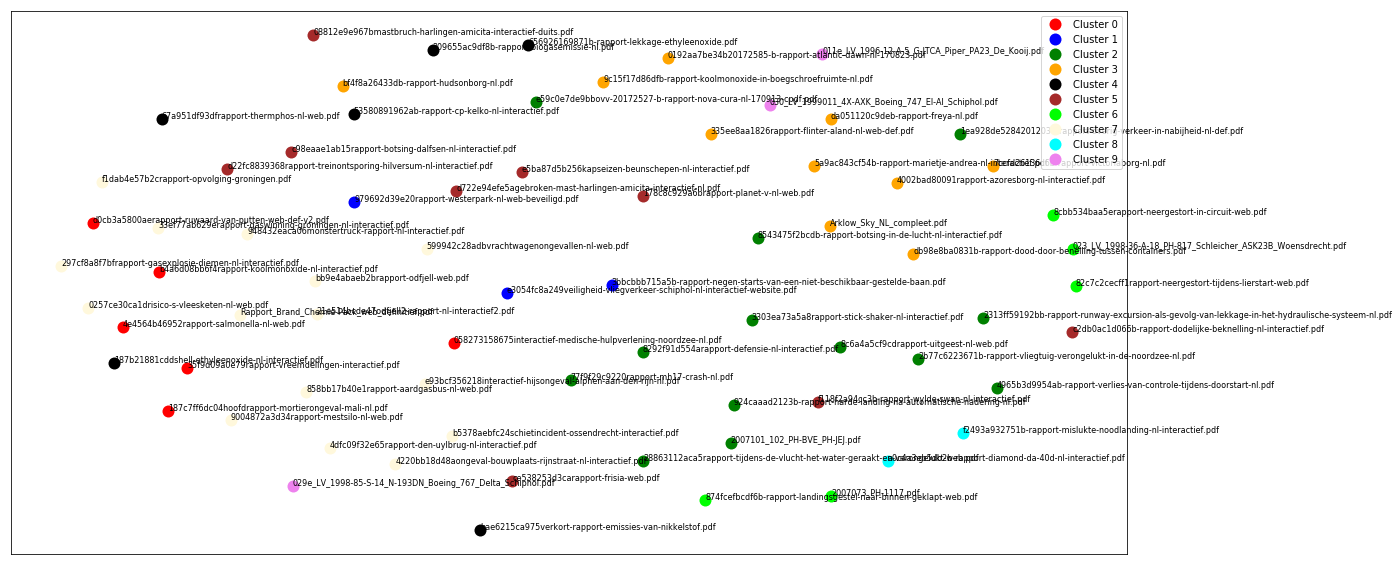

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
MDS()

# dimension reduction -> reduce multi-dimensional field to 2 dimensions for plotting
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:,0], pos[:,1]

# visualize clusters
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=textdict.keys())) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

cluster_names = ['Cluster '+str(w) for w in np.arange(np.min(clusters),np.max(clusters)+1,1)]
cluster_colors = ['r','b','g','orange','k','brown','lime','cornsilk',
                  'aqua','violet','grey','gold','darkred']

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('./Plots/Rapporten-clusters_plot.pdf')

In [106]:
import mpld3
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}
        
#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -100px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,8)) #set plot size
ax.margins(0.00) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

print 'Gebruik de muis om te zoomen'

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)

### Hierarchical document clustering


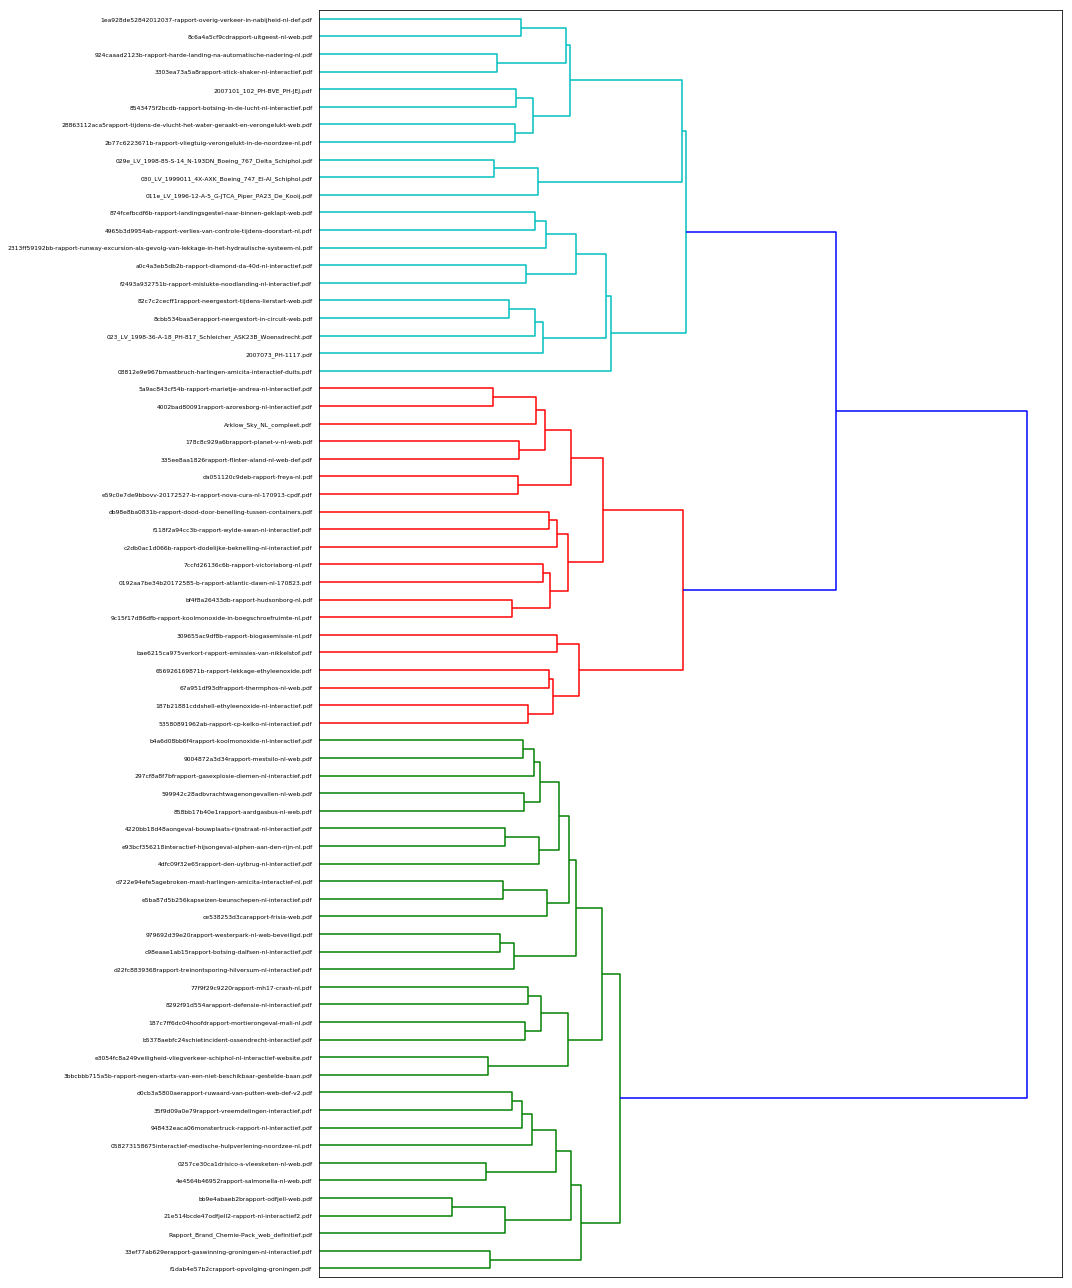

In [100]:
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt
%matplotlib inline

dist = 1 - cosine_similarity(tfidf_matrix)
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 15./60*len(textdict.keys())))

ax = dendrogram(linkage_matrix, orientation="right", labels=textdict.keys());

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('Rapport-dendogram_plot.pdf', dpi=80)

## Latent Dirichlet Allocation - Topic Modeling

Om meer van de verborgen structuur in de tekstdocumenten te vinden kunnen we gebruik maken van _Latend Dirichlet Allocation_. LDA is een propabilistisch topic model die aanneemt dat documenten een mix zijn van verschillende onderwerpen (topics) en dat elk woord in het document bijdraagt aan dit onderwerp (en zo komt het onderwerp tot stand).

![Image of Yaktocat](http://mengjunxie.github.io/ae-lda/img/IntroToLDA.png)

Om LDA te gebruiken moeten we eerst een model trainen met de data (teksten) die we hebben.

#### LDA model parameters
Voor het trainen van een LDA model gebruiken we de standaard implementatie van `gensim`. In dit model zijn een aantal aan te passen parameters:

1. __no_below__: houd tokens die minstens in dit aantal documenten aanwezig zijn.
2. __no_above__: verwijder tokens die in dit aantal (fractie van totaal) documenten aanwezig zijn.
3. __num_topics__: aantal te identificeren topic clusters. Dit is een van de belangrijkste parameters.
4. __update_every__: aantal chunks die verwerkt worden voordat de stap wordt gemaakt van E naar M (EM: Expectation Maximization).
5. __chunk_size__: aantal documenten die tegelijkertijd in geheugen geladen wordt.

Voor meer info: https://miningthedetails.com/blog/python/lda/GensimLDA/

Eerst importeren we de benodigde toolkits:

In [101]:
import string
from gensim import corpora, models, similarities

We maken nu een dictionary van alle tokens in onze `textdict` variabele.

In [102]:
# create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(textdict.values())

# remove extremes
dictionary.filter_extremes(no_below=1, no_above=0.8)

# convert dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in textdict.values()]

In [110]:
# train the LDA model - TAKES A LONG TIME!
%time lda = models.LdaModel(corpus, num_topics=10,id2word = dictionary,update_every=1,chunksize=100000,passes=50)

CPU times: user 12min 4s, sys: 15min 19s, total: 27min 24s
Wall time: 5min 20s


Laat de eerste 20 woorden zien van elk topic:

In [111]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

# show topics
topics_matrix

[(0,
  [(u'lucht', 0.01257356),
   (u'schiphol', 0.011516845),
   (u'baan', 0.01129789),
   (u'trein', 0.0079783043),
   (u'verkeers', 0.0079253819),
   (u'lvnl', 0.0068742787),
   (u'spoor', 0.0055600828),
   (u'haven', 0.0052980692),
   (u'sein', 0.0042636483),
   (u'leider', 0.0042457222),
   (u'runway', 0.0041200505),
   (u'treinen', 0.0039701853),
   (u'heids', 0.0039569968),
   (u'botsing', 0.0038529772),
   (u'verkeer', 0.0033374415),
   (u'banen', 0.0032587978),
   (u'rood', 0.0029976137),
   (u'machinist', 0.0029474711),
   (u'maat', 0.0029354505),
   (u'sprinter', 0.0029347539)]),
 (1,
  [(u'vracht', 0.022188701),
   (u'wagen', 0.013310499),
   (u'heid', 0.0093434602),
   (u'chauffeurs', 0.0090168091),
   (u'chauffeur', 0.0079756873),
   (u'wagens', 0.0075541558),
   (u'ver', 0.0060306289),
   (u'transport', 0.005998482),
   (u'verkeers', 0.0055028135),
   (u'auto', 0.0050018863),
   (u'weg', 0.0049674539),
   (u'banden', 0.0042890543),
   (u'wegen', 0.0042320848),
   (u'pers

## Document classificeren met LDA



In [114]:
lda[corpus[1]]

[(2, 0.58453715), (9, 0.41496831)]

## Overig

In [ ]:
import datetime

date = np.array([])

# convert metadict date field to date array
for i in np.arange(0,len(metadict)):
    year = metadict[metadict.keys()[i]]['/CreationDate'][2:6]
    month = metadict[metadict.keys()[i]]['/CreationDate'][6:8]
    day = metadict[metadict.keys()[i]]['/CreationDate'][8:10]

    # convert to python datetime object
    date = np.append(date,datetime.date(int(year), int(month), int(day)))
    

In [ ]:
# plot dates
import matplotlib.pyplot as plt
from matplotlib import dates as pltdates

fig = plt.figure()
ax = fig.gca()

# set plot properties
plt.title("Tijdlijn rapporten", fontsize=22)
fig.set_size_inches(20,20./60*len(textdict.keys()))
fig.gca().spines['left'].set_visible(False)
fig.gca().spines['right'].set_visible(False)
fig.gca().spines['top'].set_visible(False)
fig.gca().get_yaxis().set_ticks([]) # remove y ticks
fig.gca().axes.yaxis.set_ticklabels([]) # remove y labels
plt.grid(True,which='major',axis='x')

# plot data
xplot = np.arange(0,np.shape(textdict.keys())[0])
yind = np.argsort(date) # sort date for plotting
plt.scatter(date[yind], xplot, c=(75./256,151./256,182./256),s=100) 
for i in np.arange(0,np.shape(textdict.keys())[0]):
    plt.text(date[yind[i]]+datetime.timedelta(60), i, metadict.keys()[yind[i]], fontsize=8)
    
plt.xticks(np.arange(datetime.date(min(date).year,1,1),datetime.date(max(date).year+1,1,1),365),fontsize=16,rotation=70)
    
# make sure text fits in axis
plt.xlim(fig.gca().get_xlim()[0],fig.gca().get_xlim()[1]*1.003)

# show figure and save figure to working directory
plt.savefig('Rapport-datum_plot.pdf', dpi=80, orientation='landscape')
plt.show()


# IDEE

Tekst met keywords in pdf markeren, zie voorbeelden om locatie van het woord te extracten en de tekst in het PDF bestand te highlighten:

- https://stackoverflow.com/questions/7605577/read-highlight-save-pdf-programatically
- https://stackoverflow.com/questions/22898145/how-to-extract-text-and-text-coordinates-from-a-pdf-file/
